<h1> PROJECT MACHINE LEARNING </h1>

<h4> Import the necessary packages </h4>

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
import plotly.express as px

<h4> Define the file path of the csv data file </h4>

In [3]:
file_path = "../Dataset/books.csv"

<h2> Data Trasformation part </h2>

In [4]:
books = pd.read_csv(file_path, sep=',')
test = pd.read_csv(file_path, sep=',')

In [5]:
# gets the data type of each column
books.dtypes

bookID                  int64
title                  object
authors                object
average_rating        float64
isbn                   object
isbn13                  int64
language_code          object
  num_pages             int64
ratings_count           int64
text_reviews_count      int64
publication_date       object
publisher              object
dtype: object

<h4> Rename the num_pages column </h4>

In [6]:
books.rename(columns={"  num_pages": "num_pages"}, inplace=True)

In [7]:
books.dtypes

bookID                  int64
title                  object
authors                object
average_rating        float64
isbn                   object
isbn13                  int64
language_code          object
num_pages               int64
ratings_count           int64
text_reviews_count      int64
publication_date       object
publisher              object
dtype: object

<h4> Search for invalide date and turn it to NaT </h4>

In [8]:
try:
    # Convert the 'publication_date' column to datetime with 'coerce' option to handle invalid dates
    books['publication_date'] = pd.to_datetime(books['publication_date'], errors='coerce')
    
    # Find rows with invalid dates
    invalid_dates = books[books['publication_date'].isnull()]
    
    # Print the rows with invalid dates
    print(invalid_dates[['bookID', 'average_rating', 'publication_date']])
    
except Exception as e:
    print(e)


       bookID  average_rating publication_date
8180    31373            4.10              NaT
11098   45531            3.96              NaT


In [9]:
new_types_dict = {"title":"string", "authors":"string", "language_code":"category", "publisher":"category","isbn":"string", "isbn13":"string","average_rating":"float64","num_pages":"int64", "ratings_count":"int64","text_reviews_count":"int64","publication_date": "datetime64[ns]"}

# turn the books dataframe into a dataframe with the new types
books = books.astype(new_types_dict)
books.dtypes

bookID                         int64
title                 string[python]
authors               string[python]
average_rating               float64
isbn                  string[python]
isbn13                string[python]
language_code               category
num_pages                      int64
ratings_count                  int64
text_reviews_count             int64
publication_date      datetime64[ns]
publisher                   category
dtype: object

<h4> Make language code lowercase </h4>

In [10]:
books["language_code"] = books["language_code"].str.lower()

# print all values of books["language_code"] distinct with their occurence count
books["language_code"].value_counts()

language_code
eng      8911
en-us    1409
spa       218
en-gb     214
fre       144
ger        99
jpn        46
mul        19
zho        14
grc        11
por        10
en-ca       7
ita         5
enm         3
lat         3
swe         2
rus         2
srp         1
nl          1
msa         1
glg         1
wel         1
ara         1
nor         1
tur         1
gla         1
ale         1
Name: count, dtype: int64

<h4> Verify if there are null values </h4>

In [11]:
books.isnull().sum()

bookID                0
title                 0
authors               0
average_rating        0
isbn                  0
isbn13                0
language_code         0
num_pages             0
ratings_count         0
text_reviews_count    0
publication_date      2
publisher             0
dtype: int64

In [12]:
books[books['publication_date'].isnull()]

,bookID,title,authors,average_rating,isbn,isbn13,language_code,num_pages,ratings_count,text_reviews_count,publication_date,publisher
8180,31373,In Pursuit of the Proper Sinner (Inspector Lyn...,Elizabeth George,4.10,0553575104,9780553575101,eng,718,10608,295,NaT,Bantam Books
11098,45531,Montaillou village occitan de 1294 à 1324,Emmanuel Le Roy Ladurie/Emmanuel Le Roy-Ladurie,3.96,2070323285,9782070323289,fre,640,15,2,NaT,Folio histoire


<h2> Data Analysis part </h2>

In [13]:
pd.options.display.float_format = '{:.2f}'.format
books.describe()[['average_rating', 'ratings_count', 'text_reviews_count']]

,average_rating,ratings_count,text_reviews_count
count,11127.00,11127.00,11127.00
mean,3.93,17936.41,541.85
min,0.00,0.00,0.00
25%,3.77,104.00,9.00
50%,3.96,745.00,46.00
75%,4.13,4993.50,237.50
max,5.00,4597666.00,94265.00
std,0.35,112479.44,2576.18


In [14]:
books.corr(numeric_only = True)

,bookID,average_rating,num_pages,ratings_count,text_reviews_count
bookID,1.00,-0.04,-0.03,-0.08,-0.08
average_rating,-0.04,1.00,0.15,0.04,0.03
num_pages,-0.03,0.15,1.00,0.03,0.04
ratings_count,-0.08,0.04,0.03,1.00,0.87
text_reviews_count,-0.08,0.03,0.04,0.87,1.00


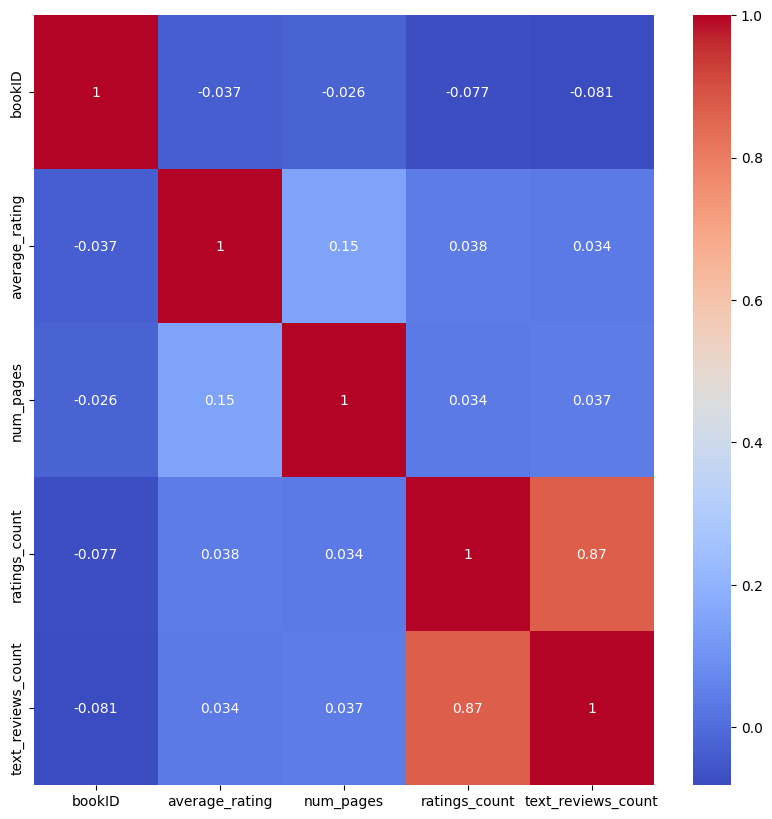

In [15]:
plt.figure(figsize=(10, 10))
sns.heatmap(books.corr(numeric_only = True), annot=True, cmap='coolwarm')
plt.show()

<p> From the outputs above, we can deduce that the ratings count has a high correlation coefficient with the text_review_count </p>

In [16]:
from matplotlib import pyplot as plt

In [17]:
px.scatter(data_frame=books,x='average_rating',y='ratings_count',color='text_reviews_count',title='Average Rating vs Ratings Count')

<p> Here, I decided to remove some outliers to improve the dataset </p>

In [18]:
books = books[(books['text_reviews_count'] != 94265) & (books['average_rating'] != 3.59)]
books = books[(books['average_rating'] != 0 ) & (books['ratings_count'] != 0)]
books = books[(books['average_rating'] != 1 ) & (books['ratings_count'] != 1)]

In [19]:
px.scatter(data_frame=books,x='average_rating',y='ratings_count',color='text_reviews_count',title='Average Rating vs Ratings Count (outliers removed)')

In [20]:
px.scatter(data_frame=books, x='average_rating', y='num_pages', color='language_code', title='Average Rating vs. Number of Pages')

In [21]:
px.scatter(data_frame=books, x='publication_date', y='average_rating', color='language_code', title='Average Rating vs. Publication Date')

<h4> We take a closer look at the chart for the books published after 1950 </h4>

In [22]:
books_bis = books.copy()

# convert publication_date to datetime format
books_bis['publication_date'] = pd.to_datetime(books_bis['publication_date'], format='%m/%d/%Y')

# leave out all the rows with publication_date < 1950
books_bis = books_bis[books_bis['publication_date'].dt.year >= 1950]
px.scatter(data_frame=books_bis, x='publication_date', y='average_rating', color='language_code', title='Average Rating vs. Publication Date (After 1950)')

<h2> Machine Learning </h2>

In [23]:
books.index

Index([    0,     1,     2,     3,     4,     5,     6,     7,     8,     9,
       ...
       11117, 11118, 11119, 11120, 11121, 11122, 11123, 11124, 11125, 11126],
      dtype='int64', length=10917)

In [24]:
# We find the missing indexes

full_range = set(range(11127))
missing_numbers = full_range - set(books.index)
print(f"There are {len(missing_numbers)} missing indexes")

missing_numbers_list = list(missing_numbers)
missing_numbers_list.sort()
for i in range(0, len(missing_numbers_list), 10):
    print(missing_numbers_list[i:i+10])

There are 210 missing indexes
[217, 251, 253, 262, 264, 265, 375, 481, 499, 525]
[526, 624, 747, 754, 759, 786, 805, 935, 944, 987]
[1107, 1110, 1197, 1241, 1355, 1375, 1681, 1713, 1829, 1995]
[2051, 2127, 2245, 2251, 2255, 2355, 2393, 2399, 2432, 2442]
[2505, 2532, 2533, 2643, 2686, 2758, 2956, 3006, 3007, 3009]
[3056, 3133, 3160, 3234, 3235, 3240, 3349, 3380, 3493, 3503]
[3510, 3520, 3542, 3913, 4014, 4125, 4156, 4179, 4214, 4242]
[4477, 4496, 4577, 4649, 4678, 4683, 4746, 4748, 4856, 4857]
[4859, 4921, 5025, 5055, 5204, 5325, 5359, 5477, 5566, 5574]
[5650, 5672, 5698, 5726, 5781, 5809, 5841, 5844, 5889, 5927]
[5929, 5931, 5933, 6046, 6087, 6113, 6179, 6187, 6364, 6383]
[6396, 6449, 6561, 6563, 6704, 6778, 6809, 6816, 6842, 6862]
[6880, 6946, 6974, 6976, 6998, 7002, 7138, 7147, 7178, 7212]
[7280, 7290, 7402, 7550, 7576, 7637, 7646, 7754, 7769, 7800]
[7872, 7930, 7936, 8028, 8055, 8076, 8112, 8475, 8547, 8555]
[8704, 8727, 8744, 8745, 8766, 8798, 8821, 8841, 8878, 8942]
[8979, 8993, 9

In [25]:
books.sample(frac=0.2)

,bookID,title,authors,average_rating,isbn,isbn13,language_code,num_pages,ratings_count,text_reviews_count,publication_date,publisher
6830,25721,How to Be a Jewish Parent: A Practical Handboo...,Anita Diamant/Karen Kushner,3.93,0805211160,9780805211160,eng,352,52,5,2000-09-05,Schocken Books Inc
6834,25741,Collected Stories III: One Night in Brazil to ...,Isaac Bashevis Singer/Ilan Stavans,4.61,1931082634,9781931082631,eng,915,23,4,2004-07-08,Library of America
9709,38739,The Lord God Made Them All,James Herriot,4.42,0312966202,9780312966201,eng,373,12580,197,1998-09-15,St. Martin's Paperbacks
1672,5826,Bel Canto,Ann Patchett,3.93,0060838728,9780060838720,eng,352,218195,13012,2005-08-02,Harper Perennial
1066,3604,Personal Finance for Dummies,Eric Tyson/Rich Tennant,3.77,0764525905,9780764525902,eng,454,925,92,2003-08-01,John Wiley & Sons
...,...,...,...,...,...,...,...,...,...,...,...,...
8795,33906,Story of a Girl,Sara Zarr,3.66,0316014532,9780316014533,eng,192,15106,1558,2007-01-10,Little Brown Books for Young Readers
8111,31160,The Earth and Its Peoples: Volume II,Richard W. Bulliet/Daniel R. Headrick/David No...,4.07,0618471162,9780618471164,eng,34,9,0,2005-05-09,Cengage Learning
4308,15498,Var the Stick (Battle Circle #2),Piers Anthony,3.76,0552097365,9780552097369,eng,172,762,13,1975-03-21,Corgi
2182,7807,Novels 1955–1962: Lolita / Pnin / Pale Fire / ...,Vladimir Nabokov/Brian Boyd,4.41,1883011191,9781883011192,eng,916,547,39,1996-10-01,Library of America


In [26]:
from sklearn.model_selection import train_test_split

In [27]:
train_data, test_data = train_test_split(books, train_size=0.8)

In [28]:
print(f"Rows in train_data: {len(train_data)}")
print(f"Rows in test_data: {len(test_data)}")

Rows in train_data: 8733
Rows in test_data: 2184


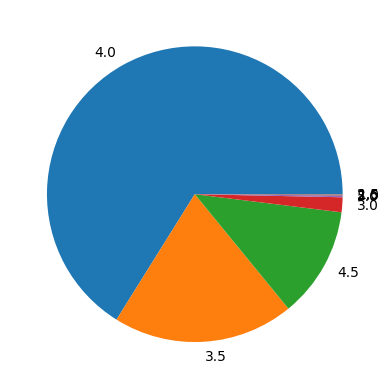

In [29]:
train_data_bis = train_data
train_data_bis['average_rating'] = np.round(train_data_bis['average_rating'] * 2) / 2
train_data_bis['average_rating'] = train_data_bis['average_rating'].clip(0.5, 5)

plt.pie(train_data_bis.average_rating.value_counts(), labels=train_data_bis.average_rating.value_counts().index)
plt.show()

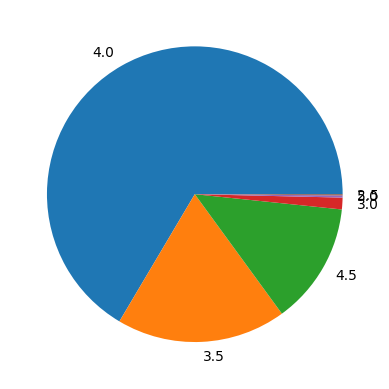

In [30]:
test_data_bis = test_data
test_data_bis['average_rating'] = np.round(test_data_bis['average_rating'] * 2) / 2
test_data_bis['average_rating'] = test_data_bis['average_rating'].clip(0.5, 5)

plt.pie(test_data_bis.average_rating.value_counts(), labels=test_data_bis.average_rating.value_counts().index)
plt.show()

In [31]:
cols = books.columns.tolist()